In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, BatchNorm1d, Dropout, Sigmoid, BCELoss
from torch.optim import Adam, SGD

from google.colab import drive
import glob
import os

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

from PIL import Image, ImageFile
from numpy.random.mtrand import shuffle

import cv2

from matplotlib import pyplot as plt

In [2]:
#File Paths
drive.mount('/content/gdrive')
PATH_ALL = "/content/gdrive/MyDrive/Colab Notebooks/Brain Tumors/ALL/"
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Brain Tumors/Brain Tumor Data Set/"
METADATA_PATH = "/content/gdrive/MyDrive/Colab Notebooks/Brain Tumors/Brain Tumor Data Set/metadata.csv"
HEALTHY_BRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/Brain Tumors/Brain Tumor Data Set/Healthy"
TUMOR_BRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/Brain Tumors/Brain Tumor Data Set/Brain Tumor"

Mounted at /content/gdrive


In [3]:
metadata = pd.read_csv(METADATA_PATH)

if Tumor in scan then set number as 1 otherwise 0

In [4]:
train_img = []
train_result = []
for index, row in metadata.iterrows():
    # reading the image
    img = imread(PATH_ALL + row['image'], as_gray=True)
    # resizing the image
    img = cv2.resize(img, (125,125), interpolation = cv2.INTER_AREA)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # appending the image into the list
    train_img.append(img)

    # if tumor then 1 otherwise 0
    if('tumor' in row['class']):
      train_result.append(1)
    else:
      train_result.append(0)

In [5]:
train_img  = np.array(train_img)
train_result = np.array(train_result)

# split the training set and test set and shuffle data
train_x, test_x, train_y, test_y = train_test_split(train_img, train_result, test_size = 0.15)

In [6]:
train_set = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_set = torch.utils.data.TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

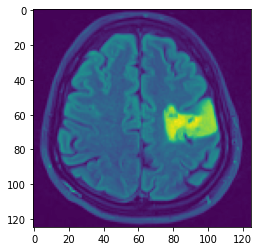

In [7]:
plt.imshow(train_img[101])
plt.show()

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=1, shuffle=True, drop_last=True)       # randomly shuffle the training data and potentially drop last batch
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=1, shuffle=False, drop_last=True)        # do not shuffle validation set and do not potentially drop last batch

In [9]:
# define CNN
class CNNNet(Module):   
    def __init__(self):
        super(CNNNet, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
            ReLU(),
            BatchNorm2d(4),

            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=2, padding=0),
            ReLU(),
            BatchNorm2d(8),

            Conv2d(8, 16, kernel_size=7, stride=2, padding=0),
            ReLU(),
            BatchNorm2d(16),


            Conv2d(16, 32, kernel_size=7, stride=2, padding=0),
            ReLU(),
            BatchNorm2d(32),

        )

        self.linear_layers = Sequential(
            Linear(512, 128),
            ReLU(),
            BatchNorm1d(128),

            Linear(128, 1),
            Sigmoid()
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


# defining the model
model = CNNNet()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [10]:
criterion = BCELoss()
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # annotate model for evaluation
    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs.reshape(128,1,125,125)) 
        output = output.reshape(128)
        output = (output>0.5).float()

        correct += torch.sum((output==labels))
        total += imgs.shape[0]

    return correct / total

EPOCH Number: 0
29 tensor(0.7443) tensor(0.7078)
EPOCH Number: 1


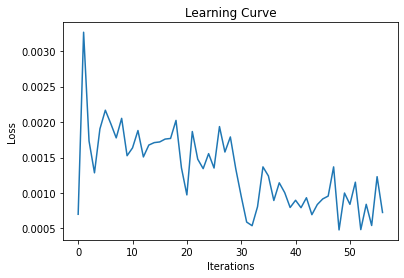

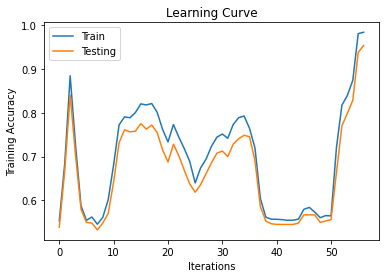

Final Training Accuracy: 0.9833333492279053
Final Testing Accuracy: 0.953125


In [27]:
def train(model, train_loader,weight_decay=0.0, optimizer="sgd", 
          learning_rate=0.01, momentum=0.9, num_epochs=50):

    # loss function
    criterion = BCELoss()
    # optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = SGD(model.parameters(), lr=learning_rate,
                              momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = Adam(model.parameters(), lr=learning_rate,
                               weight_decay=weight_decay)
        

    # track learning curve
    iters, losses, train_acc, test_acc = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    exit = False
    for epoch in range(num_epochs):
        print("EPOCH Number: " + str(epoch))
        for imgs, labels in iter(train_loader):
            model.train() # annotate model for training

            
      
            out = model((imgs.reshape(128,1,125,125)))


            
            loss = criterion(out.reshape(128).to(torch.float32),labels.to(torch.float32))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            # model.eval()
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            test_acc.append(get_accuracy(model, train=False))  # compute validation accuracy

            if train_acc[-1] > 0.95 and test_acc[-1] > 0.95:
              exit= True
              break
            n += 1
        if exit:
          break
        print(iters[-1], train_acc[-1], test_acc[-1])

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, test_acc, label="Testing")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Testing Accuracy: {}".format(test_acc[-1]))


train(model, train_loader, optimizer="adam", learning_rate=0.001,
      momentum=0.005, num_epochs=5)

In [22]:
# print(get_accuracy(model, train=True))
# print(get_accuracy(model, train=False))
# model.save_model('hello')
torch.save(model.state_dict(), PATH+"train-98_test-953")


In [13]:
# loss_fn=BCELoss()
# optimizer=SGD(model.parameters(),lr=0.01,momentum=0.9)

# train_losses=[]
# valid_losses=[]

# num_epoch = 75

# for epoch in range(1,num_epoch+1):
#   train_loss=0.0
#   valid_loss=0.0

#   model.train()
#   for img,lbl in train_loader:

#     optimizer.zero_grad()
    
#     predict=model(img[None].reshape(64,1,256,256))
#     loss=loss_fn(predict.reshape(64).to(torch.float32),lbl.to(torch.float32))
#     loss.backward()
#     optimizer.step()
#     train_loss+=loss.item()*img.size(0)

#   model.eval()
#   # for img,lbl in test_loader:

#   #   predict=model(img[None].reshape(64,1,256,256))
#   #   loss=loss_fn(predict.reshape(64).to(torch.float32),lbl.to(torch.float32))

#   #   valid_loss+=loss.item()*img.size(0)

#   train_loss=train_loss/len(train_loader.sampler) 
#   # valid_loss=valid_loss/len(test_loader.sampler)

#   train_losses.append(train_loss)
#   # valid_losses.append(valid_loss)

#   print('Epoch:{} Train Loss:{:.4f} '.format(epoch,train_loss)) 


# plt.plot(train_losses, label='Training loss')